In [2]:
# Import General Relevant Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define function for converting the prediction values to binary values (0=not part of label, 1= part of label)
def threshold_to_binary(array, threshold=0.5):
    return (array >= threshold)

In [4]:
# Prediction Matrices (Best Models) per Specified Label
os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/matrices/prediction_matrices/') # Specify Input Path
buriedpred = threshold_to_binary(np.load('pred_stack_og_jde256g.npy')[...,0])
diffusionpred = threshold_to_binary(np.load('pred_stack_r_cc256g.npy')[...,1])
metalpred = threshold_to_binary(np.load('pred_stack_r_jdi256g.npy')[...,2])
polysiliconpred = threshold_to_binary(np.load('pred_stack_r_cc256g.npy')[...,3])
viaspred = threshold_to_binary(np.load('pred_stack_og_jdi256g.npy')[...,4])

# Testset Matrices (Best Models) per Specified Label
os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/matrices/train_test_matrices/greedy/') # Specify Input Path
buriedground = np.load('jde256_ga_testlabels.npy')[...,0]
buriedvisual = np.load('jde256_ga_test.npy')

diffusionground = np.load('cc256_ga_testlabels.npy')[...,1]
# Specify the specific channels in the concatenated image in order to visualize
diffusionvisual_ccjdi = np.load('cc256_ga_test.npy')[:,:,:,0:3] 
diffusionvisual_ccjde = np.load('cc256_ga_test.npy')[:,:,:,3:6]

metalground = np.load('jdi256_ga_testlabels.npy')[...,2]
metalvisual = np.load('jdi256_ga_test.npy')

polysiliconground = np.load('cc256_ga_testlabels.npy')[...,3]
# Specify the specific channels in the concatenated image in order to visualize
polysiliconvisual_ccjdi = np.load('cc256_ga_test.npy')[:,:,:,0:3]
polysiliconvisual_ccjde = np.load('cc256_ga_test.npy')[:,:,:,3:6]

viasground = np.load('jdi256_ga_testlabels.npy')[...,4]
viasvisual = np.load('jdi256_ga_test.npy')

preds = [buriedpred, diffusionpred, metalpred, polysiliconpred, viaspred]
grounds = [buriedground, diffusionground, metalground, polysiliconground, viasground]
#visuals = [buriedvisual, diffusionvisual, metalvisual, polysiliconvisual, viasvisual]

In [5]:
# Sanity Checking: check binary values within label of prediction matrix
values, counts = np.unique(buriedpred, return_counts=True)
print("Values:", values)
print("Counts:", counts)

Values: [False  True]
Counts: [31239499   742069]


In [6]:
### Per label find highest FP cluster and FN cluster (in total 5 labels * 2 clustertypes = 10 image tiles)

# Define Function for Confusion Tiles
def confusiontiles(labelground, labelpred):
    # Create Conditions for Input
    if labelpred.shape != labelground.shape:
        raise ValueError("Both arrays must have the same size")
    if not np.all(np.isin(labelpred, [False, True])) or not np.all(np.isin(labelground, [False, True])):
        raise ValueError("All elements in the arrays must be either 0 or 1")

    confusion = np.zeros_like(labelpred, dtype=int)

    confusion[np.logical_and(labelpred == True, labelground == True)] = 1 # 1 equals a TP pixel
    confusion[np.logical_and(labelpred == False, labelground == False)] = 2 # 2 equals a TN pixel
    confusion[np.logical_and(labelpred == True, labelground == False)] = 3 # 3 equals a FP pixel
    confusion[np.logical_and(labelpred == False, labelground == True)] = 4 # 4 equals a FN pixel

    return confusion

In [7]:
# create a confusion matrices for each label
confusion_list = []

for ground, pred in zip(grounds, preds):
    confusion = confusiontiles(ground, pred)
    confusion_list.append(confusion)
    print(confusion.shape)

(488, 256, 256)
(488, 256, 256)
(488, 256, 256)
(488, 256, 256)
(488, 256, 256)


In [8]:
# Sanity Checking
values, counts = np.unique(confusion_list[1], return_counts=True)
print("Values:", values)
print("Counts:", counts)

print(len(confusion_list))

Values: [1 2 3 4]
Counts: [10554000 20852190   243194   332184]
5


In [9]:
from scipy.ndimage import label # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html

def largest_cluster(confusions, confusion_type='FP'): # FP set as default

    min_cluster_size = 100  # Set minimal clustersize that is considered a problem.
    # Keep track of largest cluster's size and index
    largest_cluster_size = 0
    largest_cluster_image_index = None

    # Define the confusion type based on the argument
    if confusion_type == 'TP':
        confusion_value = 1
    elif confusion_type == 'TN':
        confusion_value = 2
    elif confusion_type == 'FP':
        confusion_value = 3
    elif confusion_type == 'FN':
        confusion_value = 4
    else:
        raise ValueError("Invalid confusion type. Choose from 'TP', 'TN', 'FP', or 'FN'.")


    for i, confusion in enumerate(confusions):
        # Create a binary array where pixels corresponding to the specified confusion type are 1
        binary = (confusion == confusion_value)

        # Label connected components in the image
        labeled, num_clusters = label(binary)

        # Loop through each cluster and check its size
        for cluster_id in range(1, num_clusters + 1):
            size = (labeled == cluster_id).sum()
            if size > largest_cluster_size and size > min_cluster_size:
                largest_cluster_size = size # Update the largest cluster size
                largest_cluster_image_index = i # Update the index of the currently largest cluster

    return largest_cluster_image_index, largest_cluster_size



In [10]:
for confusions in confusion_list:
    print(largest_cluster(confusions, 'FP'))

(326, 750)
(448, 705)
(486, 874)
(135, 480)
(181, 643)


In [11]:
for confusions in confusion_list:
    print(largest_cluster(confusions, 'FN'))

(482, 3773)
(381, 2717)
(59, 508)
(298, 522)
(120, 741)


# Create confusion images

In [12]:
# Define Function for Confusion Tiles
def confusionimagetiles(labelground, labelpred):
    import numpy as np # Import Relevant Library
    # Create Conditions for Input
    if labelpred.shape != labelground.shape:
        raise ValueError("Both arrays must have the same size")
    if not np.all(np.isin(labelpred, [0, 1])) or not np.all(np.isin(labelground, [0, 1])):
        raise ValueError("All elements in the arrays must be either 0 or 1")

    new_shape = labelpred.shape + (3,) # Add place holder for new dimension.
    confusionimage = np.zeros(new_shape, dtype=np.uint8)
    confusionimage[np.logical_and(labelpred == 1, labelground == 1)] = [255, 255, 255]
    confusionimage[np.logical_and(labelpred == 0, labelground == 0)] = [0, 0, 0]
    confusionimage[np.logical_and(labelpred == 1, labelground == 0)] = [255, 0, 0]
    confusionimage[np.logical_and(labelpred == 0, labelground == 1)] = [255, 165, 0]
    # Delete the old dimension
    #confusionimage = np.squeeze(confusionimage, axis=3)

    return confusionimage

In [13]:
confusionimage_list = []

for ground, pred in zip(grounds, preds):
    confusion = confusionimagetiles(ground, pred)
    confusionimage_list.append(confusion)
    print(confusion.shape)

(488, 256, 256, 3)
(488, 256, 256, 3)
(488, 256, 256, 3)
(488, 256, 256, 3)
(488, 256, 256, 3)


# See errors in corresponding augmentations

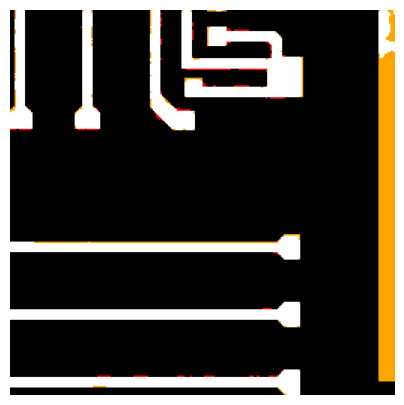

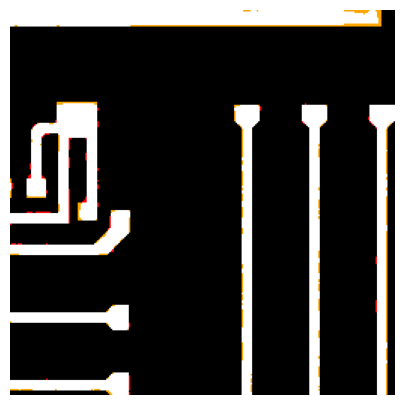

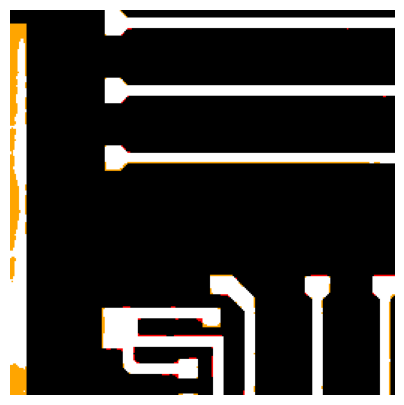

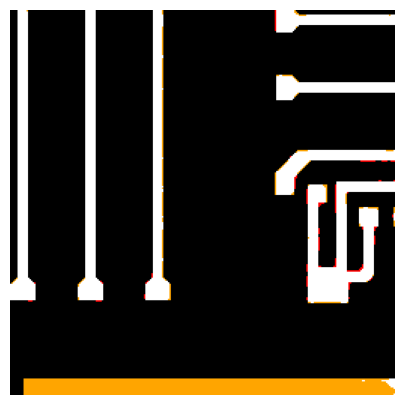

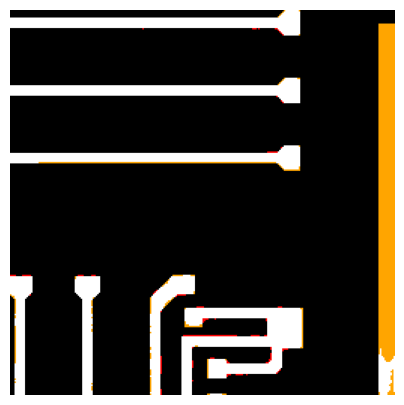

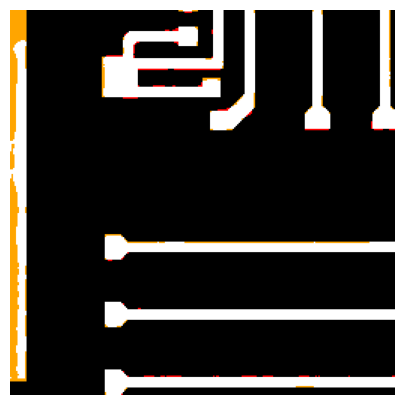

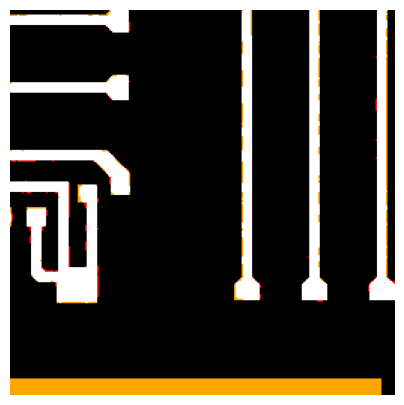

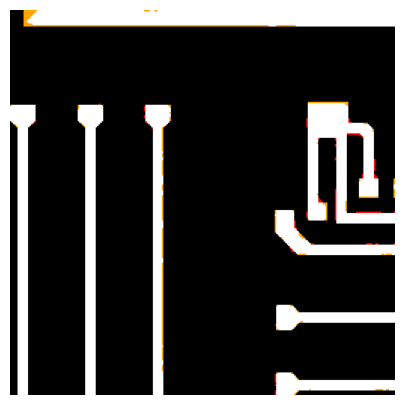

In [28]:
ilabels = [1,1,1,1,1,1,1,1] #specifying the diffusion label
diffusion_augmentations_error = [15,76,137,198,259,320,381,442]
unique_name = [1,2,3,4,5,6,7,8] #give the saved images a unique name to avoid overwriting

os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/visual_images/erroranalysis_augmentations/')

for i, j, z in zip(ilabels, diffusion_augmentations_error, unique_name):
    confusionimage = confusionimage_list[i][j].astype('uint8')
    plt.figure(figsize=(5,5))
    plt.imshow(confusionimage)
    plt.axis('off')
    plt.savefig(f'difaug{z}.png',dpi=200,bbox_inches='tight',pad_inches=0)

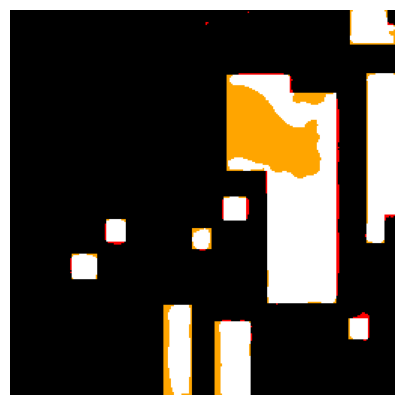

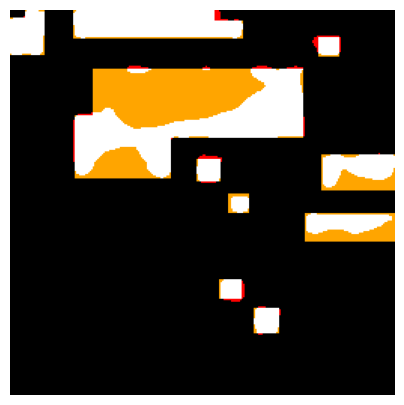

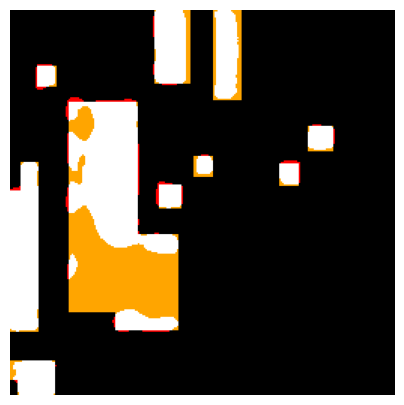

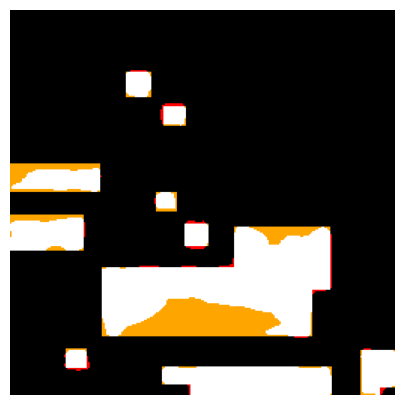

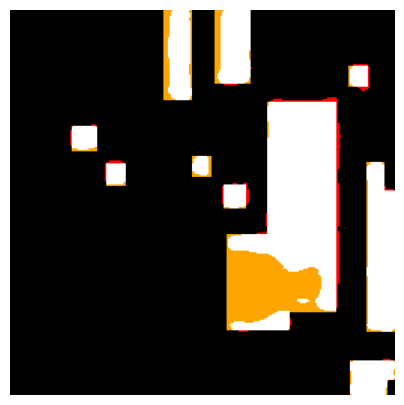

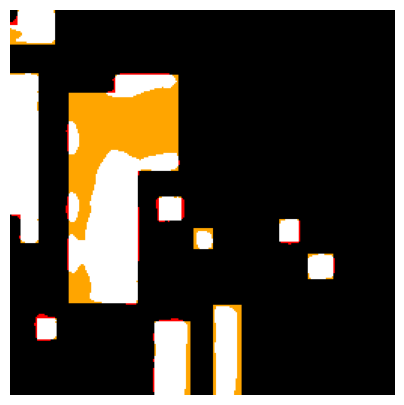

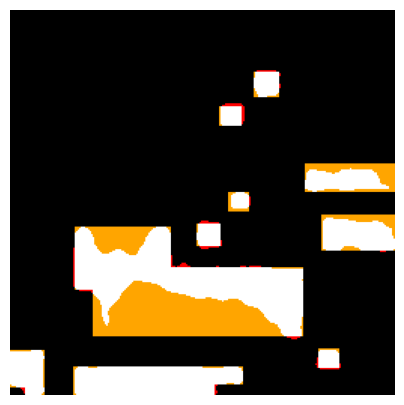

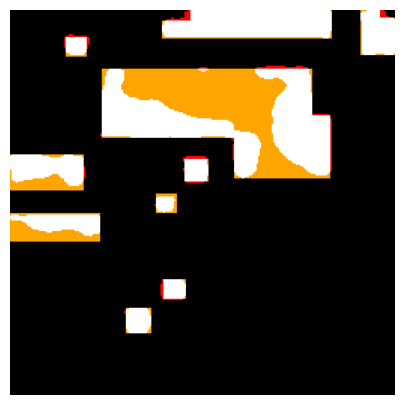

In [25]:
ilabels = [0,0,0,0,0,0,0,0] #specifying the buried label
buried_augmentations_error = [55,116,177,238,299,360,421,482]
unique_name = [1,2,3,4,5,6,7,8] #give the saved images a unique name to avoid overwriting

os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/visual_images/erroranalysis_augmentations/')

for i, j, z in zip(ilabels, buried_augmentations_error, unique_name):
    confusionimage = confusionimage_list[i][j].astype('uint8')
    plt.figure(figsize=(5,5))
    plt.imshow(confusionimage)
    plt.axis('off')
    plt.savefig(f'buraug{z}.png',dpi=200,bbox_inches='tight',pad_inches=0)

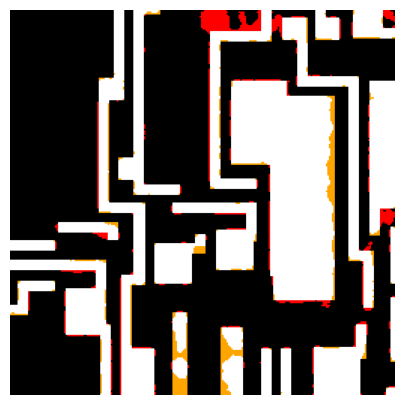

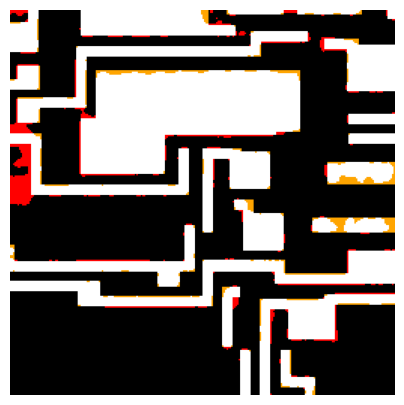

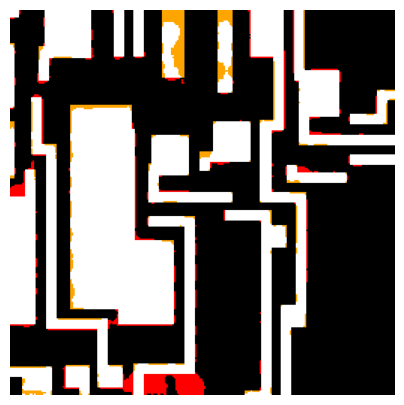

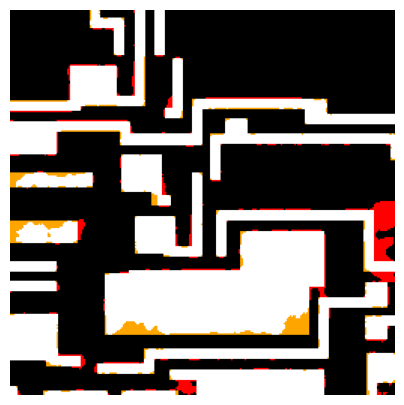

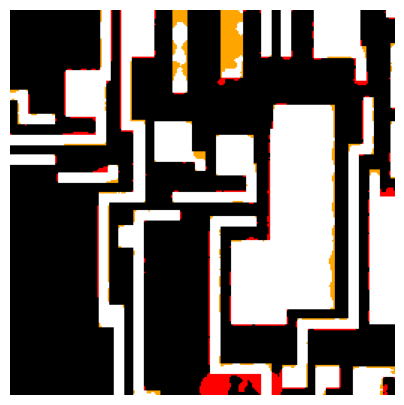

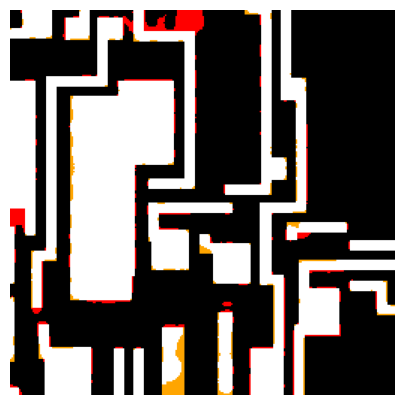

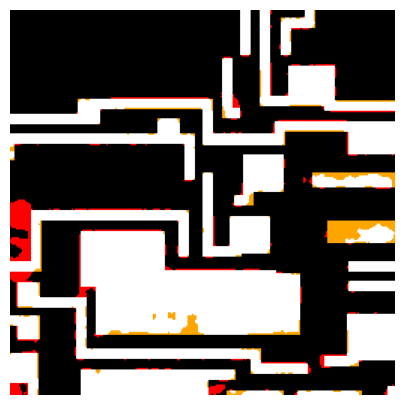

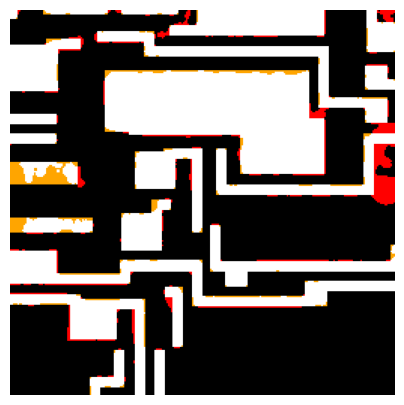

In [27]:
ilabels = [3,3,3,3,3,3,3,3] #specifying the polysilicon label
diffusion_augmentations_error = [54,115,176,237,298,359,420,481]
unique_name = [1,2,3,4,5,6,7,8] #give the saved images a unique name to avoid overwriting

os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/visual_images/erroranalysis_augmentations/')

for i, j, z in zip(ilabels, diffusion_augmentations_error, unique_name):
    confusionimage = confusionimage_list[i][j].astype('uint8')
    plt.figure(figsize=(5,5))
    plt.imshow(confusionimage)
    plt.axis('off')
    plt.savefig(f'polaug{z}.png',dpi=200,bbox_inches='tight',pad_inches=0)

# Save confusion images FP/FN

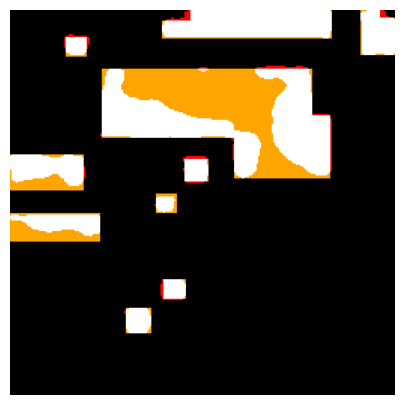

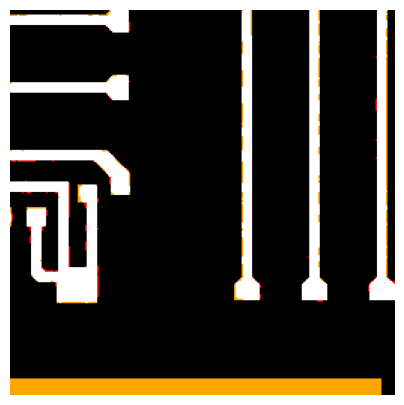

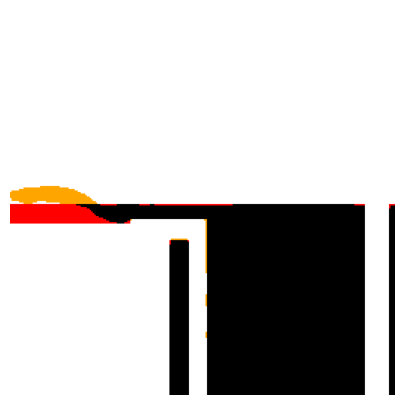

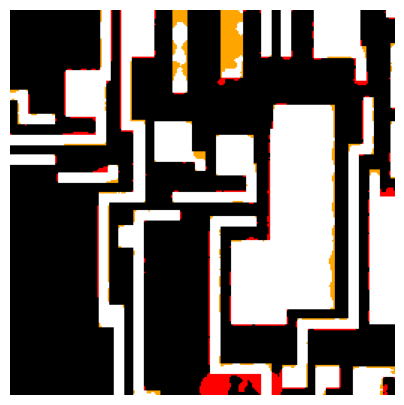

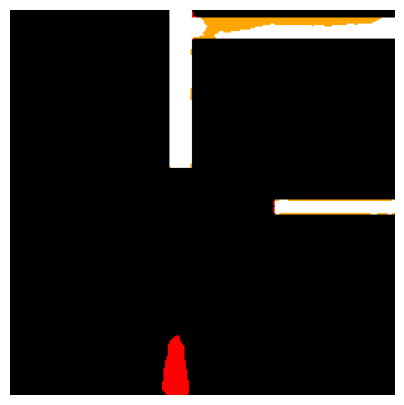

In [15]:
ilabels = [0,1,2,3,4]

fp_indices = [326,448,486,135,181]
fn_indices = [482,381,59,298,120]

os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/visual_images/bestconfusionimages/new/')

for i, j in zip(ilabels, fn_indices): # CHANGE variable NAME
    confusionimage = confusionimage_list[i][j].astype('uint8')
    plt.figure(figsize=(5,5))
    plt.imshow(confusionimage)
    plt.axis('off')
    plt.savefig(f'label{i}_fn.png',dpi=200,bbox_inches='tight',pad_inches=0) # CHANGE NAME FP/FN

# Save Corresponding Visual Images FP/FN

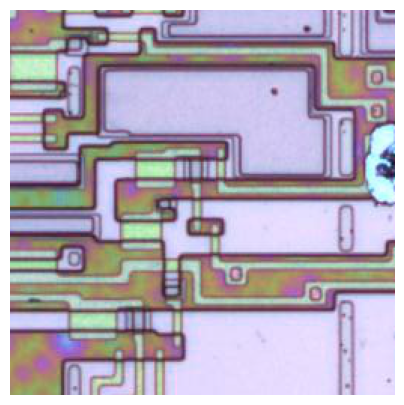

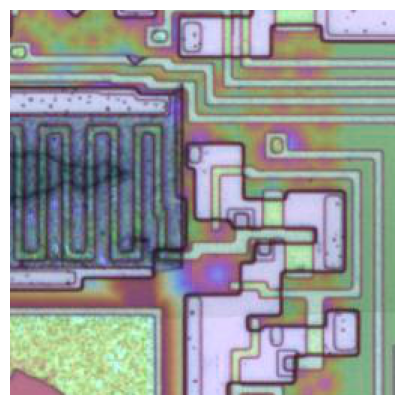

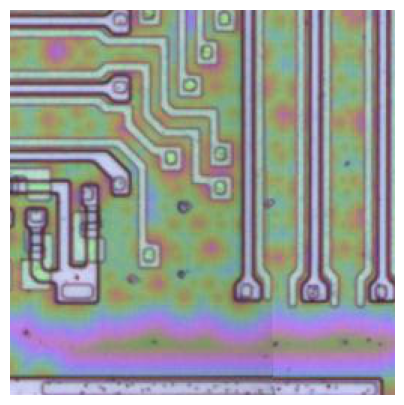

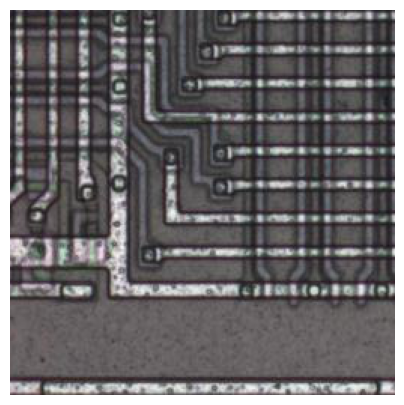

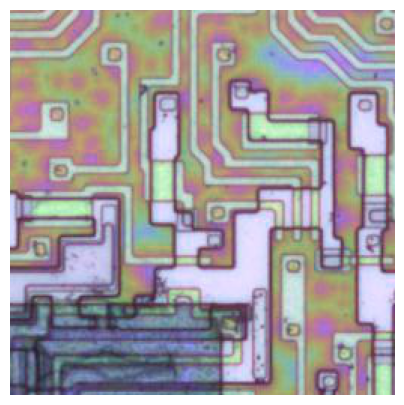

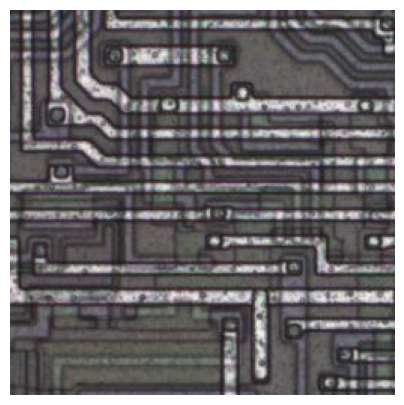

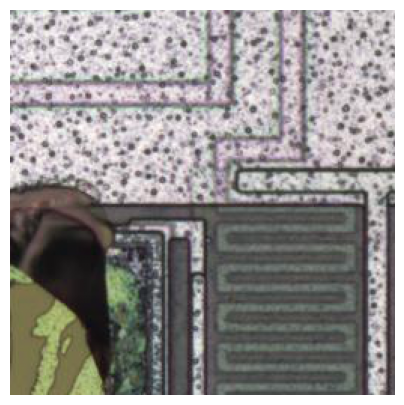

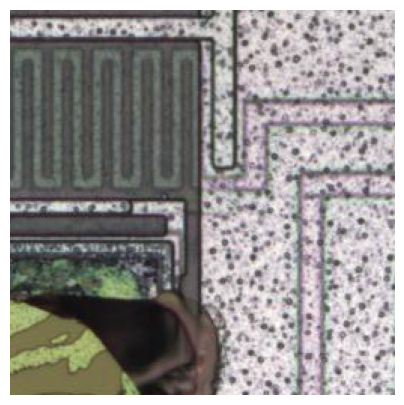

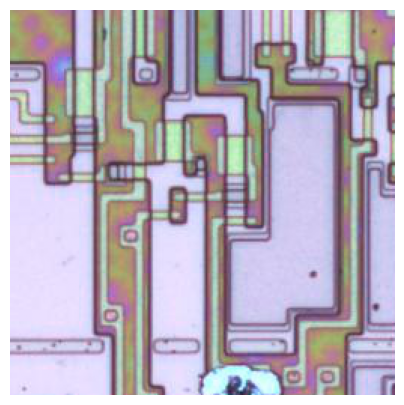

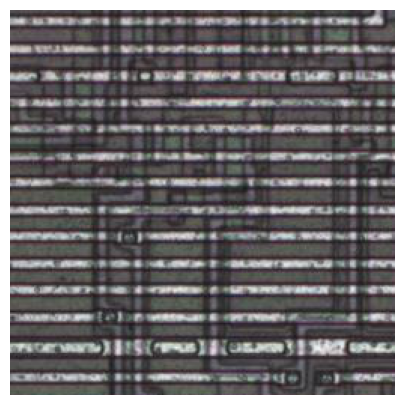

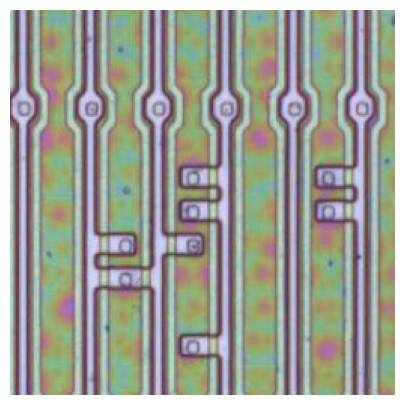

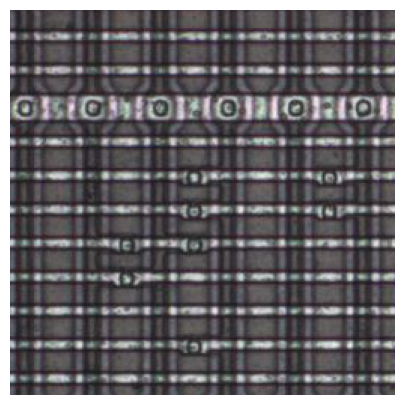

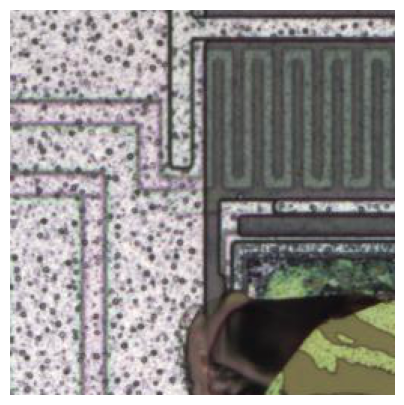

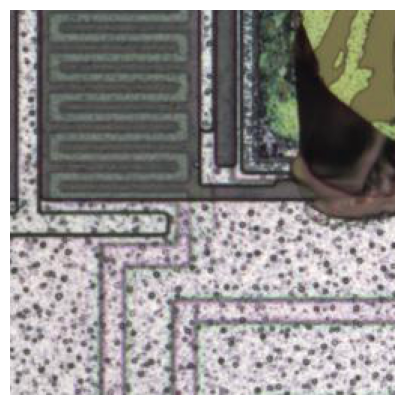

In [16]:
os.chdir('C:/Users/quint/OneDrive/qthesis/02_datasets/visual_images/bestconfusionimages/new/')

fp_indices = [326,448,486,135,181]
fn_indices = [482,381,59,298,120]

## 0. BURIED
plt.figure(figsize=(5,5))
plt.imshow(buriedvisual[482])
plt.axis('off')
plt.savefig(f'label0_fn_visual.png',dpi=200,bbox_inches='tight',pad_inches=0) 

plt.figure(figsize=(5,5))
plt.imshow(buriedvisual[326])
plt.axis('off')
plt.savefig(f'label0_fp_visual.png',dpi=200,bbox_inches='tight',pad_inches=0) 

## 1. DIFFUSION
plt.figure(figsize=(5,5))
plt.imshow(diffusionvisual_ccjde[381])
plt.axis('off')
plt.savefig(f'label1_fn_visual1.png',dpi=200,bbox_inches='tight',pad_inches=0)
plt.figure(figsize=(5,5))
plt.imshow(diffusionvisual_ccjdi[381])
plt.axis('off')
plt.savefig(f'label1_fn_visual2.png',dpi=200,bbox_inches='tight',pad_inches=0)  

plt.figure(figsize=(5,5))
plt.imshow(diffusionvisual_ccjde[448])
plt.axis('off')
plt.savefig(f'label1_fp_visual1.png',dpi=200,bbox_inches='tight',pad_inches=0)
plt.figure(figsize=(5,5))
plt.imshow(diffusionvisual_ccjdi[448])
plt.axis('off')
plt.savefig(f'label1_fp_visual2.png',dpi=200,bbox_inches='tight',pad_inches=0) 

## 2. METAL
plt.figure(figsize=(5,5))
plt.imshow(metalvisual[59])
plt.axis('off')
plt.savefig(f'label2_fn_visual.png',dpi=200,bbox_inches='tight',pad_inches=0) 

plt.figure(figsize=(5,5))
plt.imshow(metalvisual[486])
plt.axis('off')
plt.savefig(f'label2_fp_visual.png',dpi=200,bbox_inches='tight',pad_inches=0) 

## 3. POLYSILICON
plt.figure(figsize=(5,5))
plt.imshow(polysiliconvisual_ccjde[298])
plt.axis('off')
plt.savefig(f'label3_fn_visual1.png',dpi=200,bbox_inches='tight',pad_inches=0)
plt.figure(figsize=(5,5))
plt.imshow(polysiliconvisual_ccjdi[298])
plt.axis('off')
plt.savefig(f'label3_fn_visual2.png',dpi=200,bbox_inches='tight',pad_inches=0)  

plt.figure(figsize=(5,5))
plt.imshow(polysiliconvisual_ccjde[135])
plt.axis('off')
plt.savefig(f'label3_fp_visual1.png',dpi=200,bbox_inches='tight',pad_inches=0)
plt.figure(figsize=(5,5))
plt.imshow(polysiliconvisual_ccjdi[135])
plt.axis('off')
plt.savefig(f'label3_fp_visual2.png',dpi=200,bbox_inches='tight',pad_inches=0)  

## 4. VIAS
plt.figure(figsize=(5,5))
plt.imshow(viasvisual[120])
plt.axis('off')
plt.savefig(f'label4_fn_visual.png',dpi=200,bbox_inches='tight',pad_inches=0) 

plt.figure(figsize=(5,5))
plt.imshow(viasvisual[181])
plt.axis('off')
plt.savefig(f'label4_fp_visual.png',dpi=200,bbox_inches='tight',pad_inches=0) 